Recommendation System
===========

Doc2vec + Wide & Deep 을 이용한 추천시스템
----------------------------------

<div style="text-align:right"><h3>
AgileSoda | 2017.09.08.
</h3></div>

---

### 순서

1. 데이터 소개
2. Item2Vec
3. Item category
4. User Features
5. Data concate

---

본 문서에 사용된 데이터는 L.point 2016년 공모전에서 제공받은 데이터임을 밝힙니다.

---

# 데이터 소개

데이터의 행은 고객의 전체 거래상품들이 아니라 한 영수증(한 번 결제)상에 거래된 상품목록입니다. (이하 Session 이라고 표현)

해당 데이터가 꽤 크므로 간단한 분석용으로 줄였습니다.  
* C 제휴사 거래내역
* 고객별로 최대 10건의 거래내역 

각 데이터는 <U>`Agile_data.Lpoint_data_auoto_download`</U> 함수로 다운받으실 수 있습니다.

In [1]:
import copy as cp
import pandas as pd
import Agile_data

### 데이터 다운로드

In [2]:
Agile_data.Lpoint_data_auoto_download()

- Download 진행중: 100%
다운로드 완료.
언팩 완료.


In [3]:
train_data, train_categorical, train_continuous, \
train_Segment, train_label = Agile_data.load_train_data()

In [4]:
test_data, test_categorical, test_continuous, test_Segment, \
test_label, test_label_eval = Agile_data.load_test_data()

---

Wide & Deep Model의 구조는 다음과 같습니다.  모형에 Input으로 들어가는 데이터는  
__ Item, Item_Categoty, User_Features __ 총 3개의 데이터입니다.

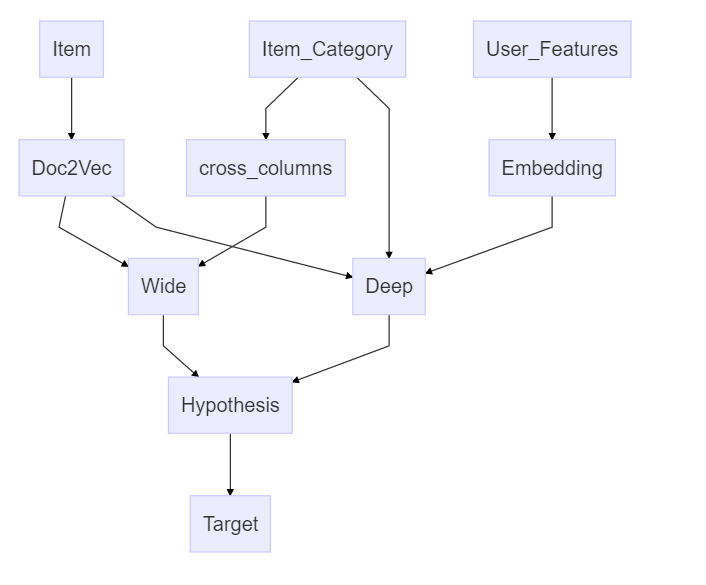

In [5]:
from IPython.display import Image
Image('images/Architecture.png')

---

## 2. Item2Vec

Item은 __구매했다. 안했다__의 바이너리 데이터입니다.  

고객/상품 | 상 품 종 류 가 .... 900개 정도
----------|--------------------------------------
ID:1      | 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 ... 0 0 0  0 0  

하지만 이렇게 0과 1로 조합된 고객의 Feature Vector는 상품의 수가 많을수록, 구매한 상품이 적을수록 sparse하므로 추가적인 무언가가 필요해 보입니다.  

여기서 NLP기술인 Doc2Vec을 사용해서 __Word Embedding -> Item Embedding__을 할 것입니다.  

고객이 구매했던 아이템들을 상품명으로 대체하고, split할 수 있게 한칸 띄어쓰기로 하나의 원소로 만듭니다.  

고객/상품 | 상 품 종 류 가 .... 900개 정도
----------|:-------------------------------------
ID:1      | 일반계란 가공우유 일반두유 ...  

그런데, 여기서 한 고객이 여태까지 구매했던 모든 아이템들을 한번에 표현하는 것은 좋다고 생각되지 않습니다. 모든 아이템들을 나열하는 것도 그 고객의 특징을 설명할 수 있겠지만, 매 거래마다 데이터를 분리하여 나열하면 그때의 구매패턴을 좀더 자세히 들여다 볼 수 있을 것이라고 판단됩니다.  

고객/상품 | 영수증 | 상 품 종 류 가..... 900개 정도
----------|:------:|:----------------------------
ID:1      | 0      |일반계란 가공우유 ...  
ID:1      | 1      |일반두유 일반 떡...  

### Doc2Vec에 Item이 들어가는 과정

In [6]:
train_data.head()

,item,영수증번호,고객번호
0,C030901/일반계란 C070103/가공우유 C110701/일반두유 C170206...,2196,3074
1,C060506/일반떡 C110305/과채음료세트 C120101/일반소주 C12050...,2243,739
2,C030109/깻잎 C030204/오이 C030301/감자 C050302/볶음탕용닭,2249,7922
3,C070102/기능성우유 C150305/쿠키케이크,2250,7922
4,C010110/딸기 C010119/사과선물세트,2262,18984


In [7]:
from gensim.models import doc2vec
from collections import namedtuple
import multiprocessing
cores = multiprocessing.cpu_count()

In [8]:
train_docs = [(str(row['item']).split(), row['고객번호']) for idx, row in train_data.iterrows()]
test_docs = [(str(row['item']).split(), row['고객번호']) for idx, row in test_data.iterrows()]

TaggedDocument = namedtuple('TaggedDocument', 'words tags')

tagged_train_docs = [TaggedDocument(d, [c]) for d, c in train_docs]
tagged_test_docs = [TaggedDocument(d, [c]) for d, c in test_docs]

> Doc2Vec의 구조는 아래와 같습니다. 이 Doc2Vec을 Item2Vec으로 바꾸는 것은 어렵지 않습니다.  
Paragraph ID를 __User ID__로 바꾸고, 학습해야 하는 단어들을 __상품명__으로 바꾸기만 하면 됩니다.   

In [9]:
tagged_train_docs[0]

TaggedDocument(words=['C030901/일반계란', 'C070103/가공우유', 'C110701/일반두유', 'C170206/종량제봉투'], tags=[3074])

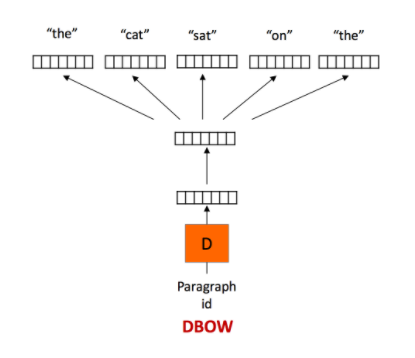

In [10]:
Image('images/DBOW.PNG')

In [11]:
if True:
    
    doc_vectorizer = doc2vec.Doc2Vec(

    dm = 0,            # PV-DBOW
    dbow_words = 1,    # w2v simultaneous with DBOW d2v / default 0
    window = 8,        # distance between the predicted word and context words 
    size = 300,        # vector size 
    sample = 1e-5,     # threshold for configuring
    min_count = 3,     # ignore with freq lower
    negative = 10,     # negative sampling / default 5

    seed = 2017,
    workers = 1,       # single cpu -> reproducible 
    alpha = 0.05,      # learning-rate
    min_alpha = 0.05   # min learning-rate

    )
    
    doc_vectorizer.build_vocab(tagged_train_docs)
    print(str(doc_vectorizer))
    
    for epoch in range(20):
        doc_vectorizer.train(tagged_train_docs)
        doc_vectorizer.alpha -= 0.002
        doc_vectorizer.min_alpha = doc_vectorizer.alpha
    
    print("Doc2Vec 학습 완료.")

Doc2Vec(dbow+w,d300,n10,w8,mc3,s1e-05)
Doc2Vec 학습 완료.


In [12]:
# To save
doc_vectorizer.save('./D2V_model/Lpoint_C.model')
# To load
doc_vectorizer=doc2vec.Doc2Vec.load('./D2V_model/Lpoint_C.model')

In [13]:
docvec = pd.DataFrame(list(doc_vectorizer.docvecs))
docvec.describe()

,0,1,2,3,4,5,6,7,8,9,...,290,291,292,293,294,295,296,297,298,299
count,19382.000000,19382.000000,19382.000000,19382.000000,19382.000000,19382.000000,19382.000000,19382.000000,19382.000000,19382.000000,...,19382.000000,19382.000000,19382.000000,19382.000000,19382.000000,19382.000000,19382.000000,19382.000000,19382.000000,19382.000000
mean,-0.075075,0.014757,0.050315,0.049293,0.049468,0.044863,0.064445,0.009794,0.036414,-0.050386,...,0.007924,-0.027202,-0.029647,-0.021419,0.060565,-0.034824,-0.033223,-0.008159,-0.006907,0.002592
std,0.083348,0.075595,0.086776,0.083618,0.082683,0.070420,0.079011,0.071640,0.081956,0.075143,...,0.072825,0.070995,0.072662,0.072705,0.089745,0.072782,0.087088,0.073056,0.060123,0.072175
min,-0.544182,-0.378248,-0.400935,-0.354720,-0.340597,-0.401087,-0.270877,-0.440499,-0.466138,-0.531340,...,-0.356092,-0.374314,-0.534926,-0.660214,-0.390227,-0.584699,-0.600650,-0.458039,-0.340240,-0.418372
25%,-0.127446,-0.008641,-0.000511,-0.000407,-0.000369,-0.000218,0.000305,-0.012927,-0.000937,-0.094541,...,-0.018313,-0.061618,-0.066431,-0.054199,-0.000090,-0.071517,-0.071738,-0.036887,-0.030074,-0.022778
50%,-0.065577,0.000836,0.024652,0.025389,0.026872,0.029412,0.052816,0.000628,0.008661,-0.034553,...,0.000382,-0.003194,-0.003357,-0.001370,0.041724,-0.011241,-0.002558,-0.000449,-0.000451,0.000152
75%,-0.000596,0.047696,0.100053,0.094234,0.094126,0.086580,0.115680,0.039986,0.075887,0.000066,...,0.034581,0.001121,0.001080,0.001453,0.114134,0.000804,0.001146,0.016285,0.013096,0.030215
max,0.417146,0.431068,0.526089,0.551103,0.515269,0.431246,0.511661,0.544187,0.581190,0.411701,...,0.389534,0.315233,0.313544,0.399806,0.540455,0.396402,0.408264,0.367080,0.322441,0.439107


> 학습된 모형에서 embedded vector를 가져오는 과정입니다.

In [14]:
train_item = [doc_vectorizer.infer_vector(doc.words) for doc in tagged_train_docs]
train_item_pd = pd.DataFrame(train_item)

test_item = [doc_vectorizer.infer_vector(doc.words) for doc in tagged_test_docs]
test_item_pd = pd.DataFrame(test_item)

In [15]:
# 300차원으로 줄어든 Item들의 기술통계량
train_item_pd.describe()

,0,1,2,3,4,5,6,7,8,9,...,290,291,292,293,294,295,296,297,298,299
count,94785.000000,94785.000000,94785.000000,94785.000000,94785.000000,94785.000000,94785.000000,94785.000000,94785.000000,94785.000000,...,94785.000000,94785.000000,94785.000000,94785.000000,94785.000000,94785.000000,94785.000000,94785.000000,94785.000000,94785.000000
mean,-0.042708,0.008488,0.033149,0.025828,0.029866,0.022014,0.030486,-0.001832,0.015434,-0.022261,...,0.003001,-0.012127,-0.014246,-0.010855,0.023210,-0.018397,-0.018835,-0.006552,0.002037,-0.000765
std,0.073410,0.030375,0.059663,0.049322,0.055646,0.042782,0.054997,0.025546,0.037742,0.044035,...,0.027393,0.033008,0.034621,0.030840,0.047190,0.039116,0.041926,0.028965,0.024334,0.028380
min,-0.383958,-0.193038,-0.151937,-0.208503,-0.173442,-0.140833,-0.144947,-0.263352,-0.251947,-0.308302,...,-0.244657,-0.274941,-0.299830,-0.281209,-0.219223,-0.323016,-0.313063,-0.264362,-0.217807,-0.263883
25%,-0.044392,-0.000712,-0.000040,0.000019,0.000037,0.000012,0.000076,-0.001464,-0.000299,-0.020899,...,-0.001172,-0.007374,-0.009861,-0.006467,-0.000080,-0.015569,-0.014758,-0.003030,-0.001186,-0.001446
50%,-0.002402,0.000580,0.001727,0.001494,0.001596,0.001516,0.001653,-0.000100,0.001075,-0.001477,...,0.000240,-0.000959,-0.001098,-0.000839,0.001407,-0.001251,-0.001299,-0.000598,0.000193,0.000016
75%,-0.000064,0.004266,0.033961,0.025501,0.029743,0.021059,0.031254,0.001195,0.010526,-0.000018,...,0.001619,0.000493,0.000343,0.000557,0.021326,0.000141,0.000099,0.000789,0.001499,0.001431
max,0.104627,0.262881,0.348534,0.325619,0.366259,0.284635,0.404910,0.228866,0.343544,0.202903,...,0.259905,0.211561,0.221132,0.189616,0.374824,0.162698,0.216904,0.211765,0.224595,0.260036


In [16]:
train_item_pd.head()

,0,1,2,3,4,5,6,7,8,9,...,290,291,292,293,294,295,296,297,298,299
0,-0.000757,0.001210,0.000719,0.001681,0.001996,0.001242,-0.000085,-0.000496,0.002182,-0.001890,...,-0.001306,-0.000914,-0.000657,0.000461,0.001725,-0.000455,-0.002625,0.000984,-0.000288,0.000508
1,-0.229485,-0.120076,0.090476,-0.011354,-0.004279,0.177423,0.122731,0.019867,0.102183,-0.143541,...,0.016679,0.021959,-0.089692,0.011707,0.031924,-0.056027,-0.012772,-0.077111,0.000561,0.094110
2,-0.063811,0.006715,0.025582,0.026700,0.039148,0.031651,0.043512,-0.004721,0.021008,-0.036353,...,-0.001745,0.004600,-0.008792,-0.029369,0.026169,-0.008562,-0.010644,-0.001147,-0.004629,0.005065
3,-0.000987,-0.000077,-0.000715,0.000863,-0.000943,-0.001618,-0.000788,0.000629,-0.001158,0.000429,...,0.001236,0.000173,0.001569,0.000422,-0.001402,0.000390,0.001616,-0.000429,0.000136,0.000900
4,-0.000302,0.000996,0.003372,0.002128,-0.000012,-0.000174,0.002966,0.000715,0.001500,-0.002877,...,0.002978,0.000709,-0.000985,-0.001552,0.000042,-0.002178,-0.003290,-0.001807,-0.000140,-0.001908


> Train 데이터를 이용해서 고객별 session 을 Doc2Vec 으로 학습하였습니다.  
884개의 Item을 300 차원으로 embedding하여 각 column들이 Items 의 특징을 가지게 되었습니다.

---

## 3. Item Category

다시한번 예시 고객을 살펴보면, ID:1 고객이 __일반계란과 가공우유__ 또는 __일반계란과 일반두유__를 같이 구매할 가능성은 어떻게 될지 생각해보겠습니다.

고객/상품 | 상 품 종 류 가 .... 900개 정도
----------|:-------------------------------------
ID:1      | 일반계란 가공우유 일반두유 ...  

이러한 가능성을 구하는 것은 Liear model에서  __교차 특성__을 통해 실현이 가능합니다.  
이 교차 특성은 두 상품의 이진법(0, 1) 원소들의 __AND__ 방식으로 구현할 수 있습니다.  

하지만 이러한 방식이 너무 특별한 경우에 국한되었다고 생각될 수 있습니다.  

다른 상품들에 대해서도 일반화를 시키려면 문제가 있습니다. 이러한 문제는 각 상품의 상위 카테고리와 같은 덜 구체적인 값들을 사용하면 해결할 수 있습니다.

In [17]:
train_Segment.head()

,X1,X2,X3,X4,X5,X6,X7,X8,X9,X10,X11,X12,X13,X14,X15,X16,X17
0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0
1,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,1.0,1.0,1.0
2,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
4,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


Item Category는 각 아이템들의 상위 카테고리를 뜻합니다.  
예를들어 __일반계란__은 __X3__카테고리에 속합니다.  
이렇게 고객들이 해당 카테고리의 상품을 하나라도 구매했다면 해당 원소는 1로 표시됩니다.  

In [18]:
def cross_columns(data, cross_colnames):
    
    del_col = data.columns
    for i in cross_colnames:
        tmp = 0
        for j in i:
            tmp += 1
            if tmp == 1:
                cross_data = data[j]
                columns = j
            else:
                cross_data = cross_data + data[j]
                columns = columns + "+" + j
        data[columns] = cross_data
        
    data.drop(del_col, inplace=True, axis=1)
        
    return data

In [19]:
cross_col = [[train_Segment.columns[i], train_Segment.columns[i + j + 1]]
        for i in range(16) for j in range(16-i)]

In [20]:
train_Segment_ = cp.deepcopy(train_Segment)
test_Segment_ = cp.deepcopy(test_Segment)
train_Segment_str = train_Segment_.astype(str)
test_Segment_str = test_Segment_.astype(str)

In [21]:
Segment = pd.concat([train_Segment_str, test_Segment_str], axis=0)

In [22]:
train_Segment_cross = cross_columns(train_Segment_str, cross_col)
test_Segment_cross = cross_columns(test_Segment_str, cross_col)

In [23]:
train_Segment_cross.head()

,X1+X2,X1+X3,X1+X4,X1+X5,X1+X6,X1+X7,X1+X8,X1+X9,X1+X10,X1+X11,...,X13+X14,X13+X15,X13+X16,X13+X17,X14+X15,X14+X16,X14+X17,X15+X16,X15+X17,X16+X17
0,0.00.0,0.01.0,0.00.0,0.00.0,0.00.0,0.01.0,0.00.0,0.00.0,0.00.0,0.01.0,...,0.00.0,0.00.0,0.00.0,0.01.0,0.00.0,0.00.0,0.01.0,0.00.0,0.01.0,0.01.0
1,0.00.0,0.00.0,0.00.0,0.00.0,0.01.0,0.00.0,0.00.0,0.00.0,0.00.0,0.01.0,...,1.00.0,1.01.0,1.01.0,1.01.0,0.01.0,0.01.0,0.01.0,1.01.0,1.01.0,1.01.0
2,0.00.0,0.01.0,0.00.0,0.01.0,0.00.0,0.00.0,0.00.0,0.00.0,0.00.0,0.00.0,...,0.00.0,0.00.0,0.00.0,0.00.0,0.00.0,0.00.0,0.00.0,0.00.0,0.00.0,0.00.0
3,0.00.0,0.00.0,0.00.0,0.00.0,0.00.0,0.01.0,0.00.0,0.00.0,0.00.0,0.00.0,...,0.00.0,0.01.0,0.00.0,0.00.0,0.01.0,0.00.0,0.00.0,1.00.0,1.00.0,0.00.0
4,1.00.0,1.00.0,1.00.0,1.00.0,1.00.0,1.00.0,1.00.0,1.00.0,1.00.0,1.00.0,...,0.00.0,0.00.0,0.00.0,0.00.0,0.00.0,0.00.0,0.00.0,0.00.0,0.00.0,0.00.0


> __AND__ 방식으로 계산된 상위 카테고리 데이터들은 __{T, T}, {T, F}, {F, T}, {F, F}__ 처럼 4개의 원소를 가지고 있으므로 모형의 Input 변수로 넣기위해 더미화 합니다.

In [24]:
train_Segment_cross_d = pd.get_dummies(train_Segment_cross)
test_Segment_cross_d = pd.get_dummies(test_Segment_cross)

train_Segment_cross_d.head()

,X1+X2_0.00.0,X1+X2_0.01.0,X1+X2_1.00.0,X1+X2_1.01.0,X1+X3_0.00.0,X1+X3_0.01.0,X1+X3_1.00.0,X1+X3_1.01.0,X1+X4_0.00.0,X1+X4_0.01.0,...,X15+X16_1.00.0,X15+X16_1.01.0,X15+X17_0.00.0,X15+X17_0.01.0,X15+X17_1.00.0,X15+X17_1.01.0,X16+X17_0.00.0,X16+X17_0.01.0,X16+X17_1.00.0,X16+X17_1.01.0
0,1,0,0,0,0,1,0,0,1,0,...,0,0,0,1,0,0,0,1,0,0
1,1,0,0,0,1,0,0,0,1,0,...,0,1,0,0,0,1,0,0,0,1
2,1,0,0,0,0,1,0,0,1,0,...,0,0,1,0,0,0,1,0,0,0
3,1,0,0,0,1,0,0,0,1,0,...,1,0,0,0,1,0,1,0,0,0
4,0,0,1,0,0,0,1,0,0,0,...,0,0,1,0,0,0,1,0,0,0


---

## 4. User Features

Deep learning 쪽에 들어갈 고객의 특성데이터는 다음과 같습니다.

1. 범주형 데이터 (성별, 연령대, 거주지역)
2. 연속형 데이터 (맴버십 가입여부, 경쟁사 이용횟수)

In [25]:
train_categorical.head()

,성별,연령대,A거주지역
0,F,50세~54세,A24
1,F,60세이상,A100
2,F,35세~39세,A210
3,F,35세~39세,A210
4,F,50세~54세,A100


In [26]:
train_continuous.head()

,다둥이,더영,롭스,하이마트,A01,A02,B01,B02,C01,C02,C03,D01,D02
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
3,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
4,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


> 고객 특징인 데이터들을 합치고 범주형 데이터는 더미화 합니다.
Deep learning에 들어갈 embedding기술은 tensorflow의 embedding_lookup함수로 구현됩니다.   
(성별 데이터는 바이너리값을 취하므로 embedding하지 않습니다.)  
이때 categorical 변수가 one-hot인코딩이 아니라 factor로 입력을 해야하기 때문에 아래와 같이 cateogorical to number 을 해줍니다.

In [27]:
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()

In [28]:
train_categorical["성별"] = le.fit_transform(train_categorical["성별"])
train_categorical["연령대"] = le.fit_transform(train_categorical["연령대"])
train_categorical["A거주지역"] = le.fit_transform(train_categorical["A거주지역"])

train_user_feartures = pd.concat([train_continuous, train_categorical], axis=1)

In [29]:
test_categorical["성별"] = le.fit_transform(test_categorical["성별"])
test_categorical["연령대"] = le.fit_transform(test_categorical["연령대"])
test_categorical["A거주지역"] = le.fit_transform(test_categorical["A거주지역"])

test_user_feartures = pd.concat([test_continuous, test_categorical], axis=1)

In [30]:
train_user_feartures.head()

,다둥이,더영,롭스,하이마트,A01,A02,B01,B02,C01,C02,C03,D01,D02,성별,연령대,A거주지역
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,7,6
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,9,1
2,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0,4,5
3,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0,4,5
4,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,7,1


In [31]:
train_user_feartures.shape

(94785, 16)

In [32]:
test_user_feartures.shape

(13915, 16)

> 다시한번 말하지만, Deep learing쪽 구조를 보게되면 고객의 특성이 embedding을 통해 학습이 된다고 나와있습니다.  
이 부분은 전처리 작업에 속하는 것이 아니라 학습을 통해 그 값이 계속 변하면서 embedding이 됩니다. 그리고 embedding 되는 변수는 다음과 같습니다.

In [33]:
train_user_feartures[["연령대", "A거주지역"]].head()

,연령대,A거주지역
0,7,6
1,9,1
2,4,5
3,4,5
4,7,1


---

## 5. Data concate

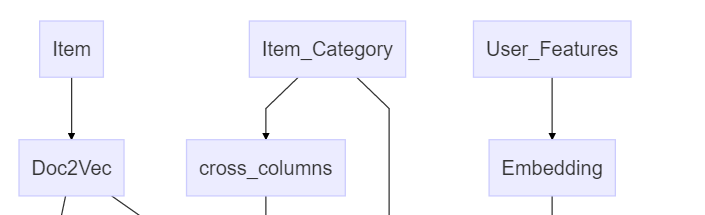

In [34]:
Image('images/Architecture_pre.png')

지금까지 진행한 전처리작업은 위 그림과 같습니다.  
이제 따로따로 처리하였던 데이터들을 하나로 합쳐 Input 데이터 형식처럼 만들어 주어야 합니다.  


### Wide 에 들어갈 Input 형식입니다.

In [35]:
Wide_data = pd.concat([train_item_pd, train_Segment_cross_d], axis=1)
Wide_data_test = pd.concat([test_item_pd, test_Segment_cross_d], axis=1)

print(Wide_data.shape)
print(Wide_data_test.shape)

Wide_data.head()

(94785, 844)
(13915, 844)


,0,1,2,3,4,5,6,7,8,9,...,X15+X16_1.00.0,X15+X16_1.01.0,X15+X17_0.00.0,X15+X17_0.01.0,X15+X17_1.00.0,X15+X17_1.01.0,X16+X17_0.00.0,X16+X17_0.01.0,X16+X17_1.00.0,X16+X17_1.01.0
0,-0.000757,0.001210,0.000719,0.001681,0.001996,0.001242,-0.000085,-0.000496,0.002182,-0.001890,...,0,0,0,1,0,0,0,1,0,0
1,-0.229485,-0.120076,0.090476,-0.011354,-0.004279,0.177423,0.122731,0.019867,0.102183,-0.143541,...,0,1,0,0,0,1,0,0,0,1
2,-0.063811,0.006715,0.025582,0.026700,0.039148,0.031651,0.043512,-0.004721,0.021008,-0.036353,...,0,0,1,0,0,0,1,0,0,0
3,-0.000987,-0.000077,-0.000715,0.000863,-0.000943,-0.001618,-0.000788,0.000629,-0.001158,0.000429,...,1,0,0,0,1,0,1,0,0,0
4,-0.000302,0.000996,0.003372,0.002128,-0.000012,-0.000174,0.002966,0.000715,0.001500,-0.002877,...,0,0,1,0,0,0,1,0,0,0


### Deep 에 들어갈 Input 형식입니다.

In [36]:
Deep_data = pd.concat([train_item_pd, train_Segment, train_user_feartures], axis=1)
Deep_data_test = pd.concat([test_item_pd, test_Segment, test_user_feartures], axis=1)

print(Deep_data.shape)
print(Deep_data_test.shape)

Deep_data.head()

(94785, 333)
(13915, 333)


,0,1,2,3,4,5,6,7,8,9,...,B01,B02,C01,C02,C03,D01,D02,성별,연령대,A거주지역
0,-0.000757,0.001210,0.000719,0.001681,0.001996,0.001242,-0.000085,-0.000496,0.002182,-0.001890,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,7,6
1,-0.229485,-0.120076,0.090476,-0.011354,-0.004279,0.177423,0.122731,0.019867,0.102183,-0.143541,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,9,1
2,-0.063811,0.006715,0.025582,0.026700,0.039148,0.031651,0.043512,-0.004721,0.021008,-0.036353,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0,4,5
3,-0.000987,-0.000077,-0.000715,0.000863,-0.000943,-0.001618,-0.000788,0.000629,-0.001158,0.000429,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0,4,5
4,-0.000302,0.000996,0.003372,0.002128,-0.000012,-0.000174,0.002966,0.000715,0.001500,-0.002877,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,7,1


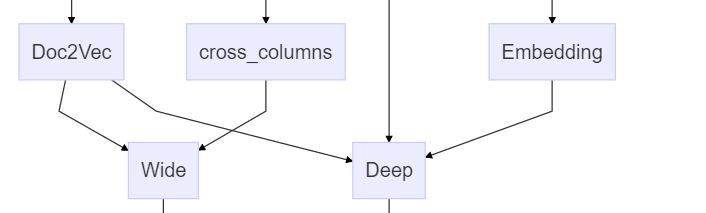

In [37]:
Image('images/Architecture_sum.png')

---

이렇게 모형에 Input 으로 집어넣을 데이터들이 만드어졌습니다.  
나중에 재사용 하기 위해 최종 데이터를 저장합니다.

In [38]:
Wide_data.to_csv("./Lpoint_data/Wide_data.csv", encoding='cp949', index=False)
Deep_data.to_csv("./Lpoint_data/Deep_data.csv", encoding='cp949', index=False)
Wide_data_test.to_csv("./Lpoint_data/Wide_data_test.csv", encoding='cp949', index=False)
Deep_data_test.to_csv("./Lpoint_data/Deep_data_test.csv", encoding='cp949', index=False)